In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Configuracion general
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
REPORTS_DIR = Path("D:/trading/reports/backtesting")


In [2]:
archivos = list(REPORTS_DIR.glob("resumen_metricas_tp*_*.csv"))
df_list = []

for archivo in archivos:
    m = re.search(r"tp(\d+)_sl(\d+)", archivo.stem)
    if m:
        tp = int(m.group(1)) / 100
        sl = int(m.group(2)) / 100
        df = pd.read_csv(archivo)
        df["tp"] = tp
        df["sl"] = sl
        df["archivo"] = archivo.name
        df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True)
print(f"Archivos cargados: {len(archivos)}")
print(f"Filas totales: {len(df_all)}")
df_all.head()


Archivos cargados: 4
Filas totales: 2364


,simbolo,estrategia,total_op,winrate,retorno_promedio,retorno_total,sharpe,profit_factor,max_drawdown,tp,sl,archivo
0,AAPL,breakout_volumen,524,0.50,0.002161,1.1326,0.05,1.14,-0.2886,0.04,0.02,resumen_metricas_tp4_sl2_2025-05-28.csv
1,AAPL,cruce_medias,161,0.44,0.001177,0.1895,0.03,1.07,-0.0134,0.04,0.02,resumen_metricas_tp4_sl2_2025-05-28.csv
2,AAPL,ema_9_21_cruce,189,0.48,0.001924,0.3637,0.05,1.12,-0.3391,0.04,0.02,resumen_metricas_tp4_sl2_2025-05-28.csv
3,AAPL,gap_open_strategy,150,0.49,0.002377,0.3565,0.04,1.11,-0.1099,0.04,0.02,resumen_metricas_tp4_sl2_2025-05-28.csv
4,AAPL,ma_envelope_reversals,2615,0.36,-0.003383,-8.8461,-0.09,0.82,-10.8603,0.04,0.02,resumen_metricas_tp4_sl2_2025-05-28.csv


In [4]:
# Filtro minimo: al menos 10 operaciones
df_filtrado = df_all[df_all["total_op"] >= 10].copy()

# Ranking por sharpe ratio
top_sharpe = df_filtrado.sort_values("sharpe", ascending=False).head(10)
print("Top combinaciones por Sharpe ratio:")
top_sharpe[["simbolo", "estrategia", "tp", "sl", "sharpe", "retorno_total", "winrate"]]


Top combinaciones por Sharpe ratio:


,simbolo,estrategia,tp,sl,sharpe,retorno_total,winrate
1357,ECCF,rsi_reversion,0.06,0.02,0.54,0.2556,0.64
1356,ECCF,rsi_divergencia,0.06,0.02,0.54,0.1285,0.60
1947,ECCF,rsi_divergencia,0.06,0.03,0.54,0.1285,0.60
174,ECCF,rsi_divergencia,0.04,0.02,0.54,0.1285,0.60
765,ECCF,rsi_divergencia,0.04,0.03,0.54,0.1285,0.60
1948,ECCF,rsi_reversion,0.06,0.03,0.54,0.2556,0.64
175,ECCF,rsi_reversion,0.04,0.02,0.54,0.2556,0.64
766,ECCF,rsi_reversion,0.04,0.03,0.54,0.2556,0.64
1837,AMD,volatilidad_contraria,0.06,0.03,0.48,0.4378,0.67
1116,TBB,volatilidad_contraria,0.04,0.03,0.47,0.1374,0.59


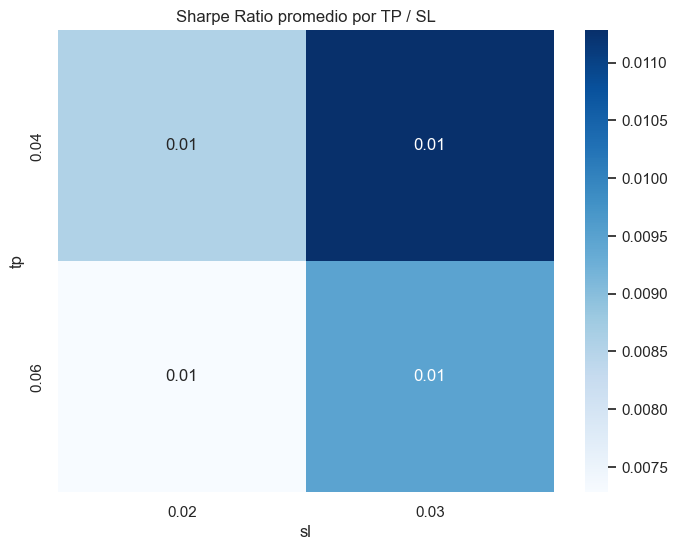

In [5]:
pivot = df_filtrado.pivot_table(index="tp", columns="sl", values="sharpe", aggfunc="mean")
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Sharpe Ratio promedio por TP / SL")
plt.show()


In [6]:
top_config = df_filtrado.sort_values("sharpe", ascending=False).head(30)
top_config.to_csv(REPORTS_DIR / "top_configuraciones_heuristicas.csv", index=False)
print("Archivo guardado:", REPORTS_DIR / "top_configuraciones_heuristicas.csv")


Archivo guardado: D:\trading\reports\backtesting\top_configuraciones_heuristicas.csv


In [7]:
estrategias_top = df_filtrado.groupby("estrategia")[["sharpe", "retorno_total", "winrate"]].mean().sort_values("sharpe", ascending=False)
estrategias_top


,sharpe,retorno_total,winrate
estrategia,,,
rsi_divergencia,0.061222,0.337227,0.478944
rsi_reversion,0.050326,0.791338,0.480272
mov_avg,0.037944,0.139812,0.473222
sma_10_50_cruce,0.033895,0.175172,0.468023
macd_cruce,0.032167,0.159179,0.460889
ma_envelope_reversals,0.029833,0.815967,0.463167
ema_9_21_cruce,0.027833,0.099461,0.469167
macd_hist_reversal,0.020598,0.067514,0.463478
cruce_medias,0.017778,0.071463,0.458833


In [8]:
# Consolidar mejores configuraciones por Sharpe, retorno_total y winrate
ranking = df_filtrado.copy()
ranking["score"] = (
    ranking["sharpe"].rank(pct=True) +
    ranking["retorno_total"].rank(pct=True) +
    ranking["winrate"].rank(pct=True)
)

top_score = ranking.sort_values("score", ascending=False).head(20)
display(top_score[["simbolo", "estrategia", "tp", "sl", "sharpe", "retorno_total", "winrate", "score"]])
top_score.to_csv(REPORTS_DIR / "top_configuraciones_consolidadas.csv", index=False)
print("Archivo guardado:", REPORTS_DIR / "top_configuraciones_consolidadas.csv")


,simbolo,estrategia,tp,sl,sharpe,retorno_total,winrate,score
729,CTVA,rsi_reversion,0.04,0.03,0.32,5.3551,0.61,2.954386
1911,CTVA,rsi_reversion,0.06,0.03,0.33,5.9010,0.59,2.947368
724,CTVA,ma_envelope_reversals,0.04,0.03,0.22,6.4280,0.58,2.909649
1906,CTVA,ma_envelope_reversals,0.06,0.03,0.22,7.1390,0.56,2.895614
1910,CTVA,rsi_divergencia,0.06,0.03,0.37,3.1694,0.59,2.892763
728,CTVA,rsi_divergencia,0.04,0.03,0.34,2.7546,0.60,2.886404
1076,RPRX,rsi_reversion,0.04,0.03,0.27,2.8083,0.61,2.880482
1075,RPRX,rsi_divergencia,0.04,0.03,0.41,1.9618,0.62,2.868421
1129,TSLA,volatilidad_contraria,0.04,0.03,0.44,1.6468,0.61,2.851096
2078,HBANL,rsi_reversion,0.06,0.03,0.39,1.5699,0.65,2.850877


Archivo guardado: D:\trading\reports\backtesting\top_configuraciones_consolidadas.csv
